## <center> Audio Generation via Generative Adversarial Netwoks (GANs) </center> 
***
This notebook aims to demo the basic steps of constructing a GANs model for Sound Generation. Freesound-Audio-Tagging dataset is used in this case, and the raw dataset is provided on Github under the audio_gan folder.

Sections:<a id='sections_audio_gan'></a>
1. [Environment Setup:](#environment_setup_audio_gan) import libraries, config audio parameters, load & prepare datasets.

2. [GANs Architecture Setup:](#GANs_Architecture_Setup)

    2.1. [To define functions for Datasets Preparation](#func_datasets_prep), 
    
    2.2. [To define functions for GANs Internal Architecture](#func_GANs_Internal_Architecture),
    
    2.3. [To define class for AudioGAN architecture](#class_AudioGAN_architecture)

3. [GANs Model Implementation:](#gan_model_implementation) training GANs, Result Interpretation & Thoughts Sharing, and Generated vs Original Samples. 

4. [Wrap Up:](#audio_gan_wrap_up) Discussion & Closing

<br>
NOTE: The naming/definition of "train", "test", "evaluate" follows how the tools (e.g. Tensorflow) names the step / define its function.
<br>
<br>

### 1. Environment Setup<a id='environment_setup_audio_gan'></a> 

[Sections](#sections_audio_gan)

In [1]:
import librosa
import numpy as np
import pandas as pd


import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn')
sns.set(style="whitegrid")


import tensorflow as tf
tf.random.set_seed(0)

In [2]:
# Config Audio Parameters
DURATION = 4
SAMPLE_RATE = 16000
AUDIO_SHAPE = SAMPLE_RATE*DURATION

NOISE_DIM = 500

# setup paths
DATASET_PATH = "./freesound-audio-tagging/"

# label
LABEL = "Trumpet"

In [3]:
# load data
train = pd.read_csv(DATASET_PATH + "train.csv")

In [4]:
# check data
train.head()

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1


### 2. GANs Architecture Setup<a id='GANs_Architecture_Setup'></a> 

[Sections](#sections_audio_gan)

#### 2.1. To define functions for Datasets Preparation <a id='func_datasets_prep'></a> 

[Sections](#sections_audio_gan)

In [5]:
# load 
def load_train_data(input_length=AUDIO_SHAPE, label = LABEL):
    train = pd.read_csv(DATASET_PATH + "train.csv")
    if label != None:
        train_list = train.loc[train.label == label]
    else: 
        train_list = train
    cur_batch_size = len(train_list)
    train_fname_list = train_list.fname
    X = np.empty((cur_batch_size, input_length))
    for i, train_fname in enumerate(train_fname_list):
        file_path = DATASET_PATH + "audio_train/" + train_fname
        
        # Read and Resample the audio
        data, _ = librosa.core.load(file_path, sr=SAMPLE_RATE, res_type='kaiser_fast')

        # Random offset / Padding
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
        X[i,] = data
    print("Data Loaded...")
    return X

# standardise Data 
def normalization(X):
    mean = X.mean(keepdims=True)
    std = X.std(keepdims=True)
    X = (X - mean) / std
    print("Data Normalized...")
    return X

#### 2.2. To define functions for GANs Internal Architecture <a id='func_GANs_Internal_Architecture'></a> 

[Sections](#sections_audio_gan)

The core idea of GANs is inspired by the game theory, which the models are built to compete with each other while making each other stronger at the same time. To achieve this core idea, **Generator Network** is designed to fool the Dicriminator Network by generating real samples; while **Discriminator Network** will attempt to distinguish between the real and fake samples. In other words, the aim of GANs Algo is to train on 2 models: Generator and Discriminator. This section aims to break down the key GANs computation into smaller blocks which can be summarised as following:
1. Generator Model
2. Discriminator Model 
3. Stacked Generator and Discriminator 

In [6]:
# Generator Model
def generator(NoiseDim, OutputShape):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(1000, input_shape=(NoiseDim,)))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.01))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
    model.add(tf.keras.layers.Reshape((1000, 1)))

    model.add(tf.keras.layers.Conv1D(16, 20, padding='same'))
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
    model.add(tf.keras.layers.Dropout(rate=0.1))

    model.add(tf.keras.layers.Conv1D(32, 25, padding='same'))
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
    model.add(tf.keras.layers.Dropout(rate=0.1))

    model.add(tf.keras.layers.Conv1D(64, 50, padding='same'))
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
    model.add(tf.keras.layers.Dropout(rate=0.1))
 
    model.add(tf.keras.layers.Conv1D(64, 100, padding='same'))
    model.add(tf.keras.layers.Dropout(rate=0.3))
    model.add(tf.keras.layers.Flatten())
    return model

# Discriminator Model
def discriminator(InputShape):
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Reshape((InputShape, 1), input_shape=(InputShape,)))
    model.add(tf.keras.layers.Conv1D(32, 100, strides=7, padding='valid'))
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.AveragePooling1D(4))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
    model.add(tf.keras.layers.Dropout(rate=0.1))

    model.add(tf.keras.layers.Conv1D(16, 50, strides=5, padding='valid'))
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
    model.add(tf.keras.layers.Dropout(rate=0.1))

    model.add(tf.keras.layers.Conv1D(8, 25, strides=3, padding='valid'))
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
    model.add(tf.keras.layers.Dropout(rate=0.1))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1024))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.01))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    return model

# Stacked Generator and Discriminator
def stacked_G_D(Generator, Discriminator):
    model = tf.keras.Sequential()
    model.add(Generator)
    model.add(Discriminator)
    return model

#### 2.3. To define class for AudioGAN architecture<a id='class_AudioGAN_architecture'></a> 

[Sections](#sections_audio_gan)

In [7]:
# define class 
class AudioGAN:
    def __init__(self, label="Electric_piano"):

        # Generate models
        self.gen = generator(NOISE_DIM, AUDIO_SHAPE)
        self.dis = discriminator(AUDIO_SHAPE)
        self.stackGenDis = stacked_G_D(self.gen, self.dis)  
        
        # Compile models
        self.opt = tf.keras.optimizers.Adam(lr = 0.0002, beta_1 = 0.9) 
        self.gen.compile(loss = 'binary_crossentropy', optimizer = self.opt, metrics = ['accuracy'])
        self.dis.compile(loss = 'binary_crossentropy', optimizer = self.opt, metrics = ['accuracy'])
        self.stackGenDis.compile(loss = 'binary_crossentropy', optimizer = self.opt,  metrics = ['accuracy'])

        # Set training data
        self.trainData = normalization(load_train_data(AUDIO_SHAPE, label))

        self.disLossHist = []
        self.genLossHist = []

    # Train GAN
    def train_gan(self, epochs = 20, batch = 32):
        for cnt in range(epochs):
          
            # Train discriminator
            halfBatch = int(batch/2)
            random_index = np.random.randint(0, len(self.trainData) - halfBatch)
            legit_audios = self.trainData[random_index: int(random_index + halfBatch)]
            gen_noise = np.random.normal(0, 1, (halfBatch, NOISE_DIM))
            syntetic_audios = self.gen.predict(gen_noise)
            x_combined_batch = np.concatenate((legit_audios, syntetic_audios))
            y_combined_batch = np.concatenate((np.ones((halfBatch, 1)), np.zeros((halfBatch, 1))))
            d_loss = self.dis.train_on_batch(x_combined_batch, y_combined_batch)
            
            # Update stacked discriminator weights
            self.stackGenDis.layers[1].set_weights(self.dis.get_weights())
    
            # Include discriminator loss
            d_loss_mean = np.mean(d_loss)
            self.disLossHist.append(d_loss_mean)

            # Train stacked generator
            noise = np.random.normal(0, 1, (batch, NOISE_DIM))
            y_mislabled = np.ones((batch, 1))
            g_loss = self.stackGenDis.train_on_batch(noise, y_mislabled)

            # Update generator Weights
            self.gen.set_weights(self.stackGenDis.layers[0].get_weights())
            
            # Include generator loss
            g_loss_mean = np.mean(g_loss)
            self.genLossHist.append(g_loss_mean)
            
            print("epoch: %d" % (cnt), " Discriminator loss: %f, Generator loss: %f" % (d_loss_mean, g_loss_mean))

### 3. GAN Model Implementation<a id='gan_model_implementation'></a> 

[Sections](#sections_audio_gan)

##### Create Audio GANs object

In [8]:
GAN = AudioGAN(label = LABEL)

Data Loaded...
Data Normalized...


##### Training GANs

In [9]:
GAN.train_gan(epochs = 50, batch = 32)

epoch: 0  Discriminator loss: 0.769196, Generator loss: 0.676465
epoch: 1  Discriminator loss: 0.617209, Generator loss: 0.700617
epoch: 2  Discriminator loss: 0.673511, Generator loss: 0.714244
epoch: 3  Discriminator loss: 0.603733, Generator loss: 0.688005
epoch: 4  Discriminator loss: 0.557409, Generator loss: 0.704348
epoch: 5  Discriminator loss: 0.519505, Generator loss: 0.685549
epoch: 6  Discriminator loss: 0.598656, Generator loss: 0.709810
epoch: 7  Discriminator loss: 0.537241, Generator loss: 0.676371
epoch: 8  Discriminator loss: 0.518977, Generator loss: 0.698710
epoch: 9  Discriminator loss: 0.591375, Generator loss: 0.707068
epoch: 10  Discriminator loss: 0.506742, Generator loss: 0.630706
epoch: 11  Discriminator loss: 0.504787, Generator loss: 0.697257
epoch: 12  Discriminator loss: 0.507509, Generator loss: 0.677969
epoch: 13  Discriminator loss: 0.524748, Generator loss: 0.715374
epoch: 14  Discriminator loss: 0.568595, Generator loss: 0.683152
epoch: 15  Discrimin

##### Plot Discriminator and Generator Loss over the Epochs

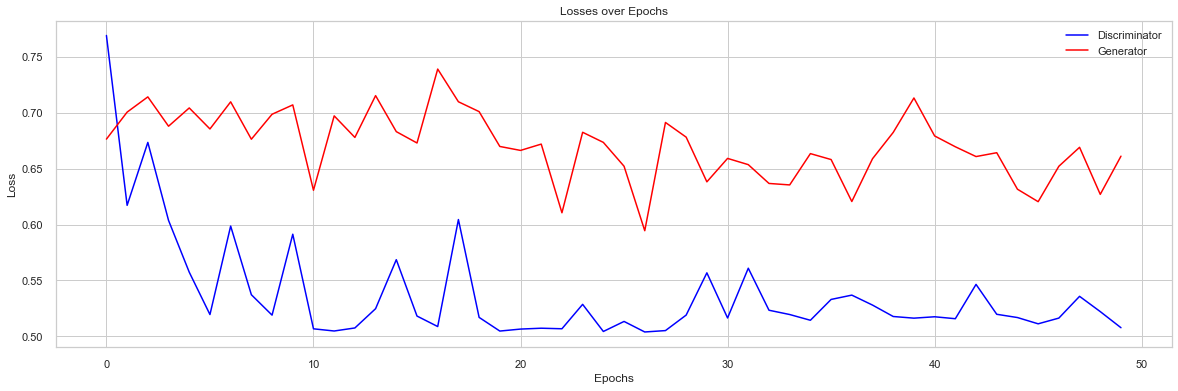

In [10]:
plt.title('Losses over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.plot(GAN.disLossHist, '-', label = 'Discriminator', color = 'blue')
plt.plot(GAN.genLossHist, '-', label = 'Generator',     color = 'red')
plt.legend(loc = 'best')

plt.gcf().set_size_inches(20, 6)
plt.show()

##### Result Interpretation & Thoughts Sharing:

As both Discriminator and Generator Networks are designed to work one against each other, naturally when one improves the other would show a higher loss. Having said that, the chart does help to understand at which Epoch Discriminator or Generator started converging. Also, since Discriminator Network is trained to be able to distinguish the real and fake samples, the rule of thumb here is to focus on how well the Discriminator has learnt. For these reasons, the Discriminator could be generally assumed to learn well when it started settling, while the Generator may hit its highest point in general for the entire training. 

Though it is always debatable if the GANs model has achieved its optimum, it never went wrong to check if the generated samples met a desirable result. Next, let’s assess the algo’s performance by listening to the generated and original samples and will leave the results as it is without giving any judgements or comments.

##### Generated Audio Samples

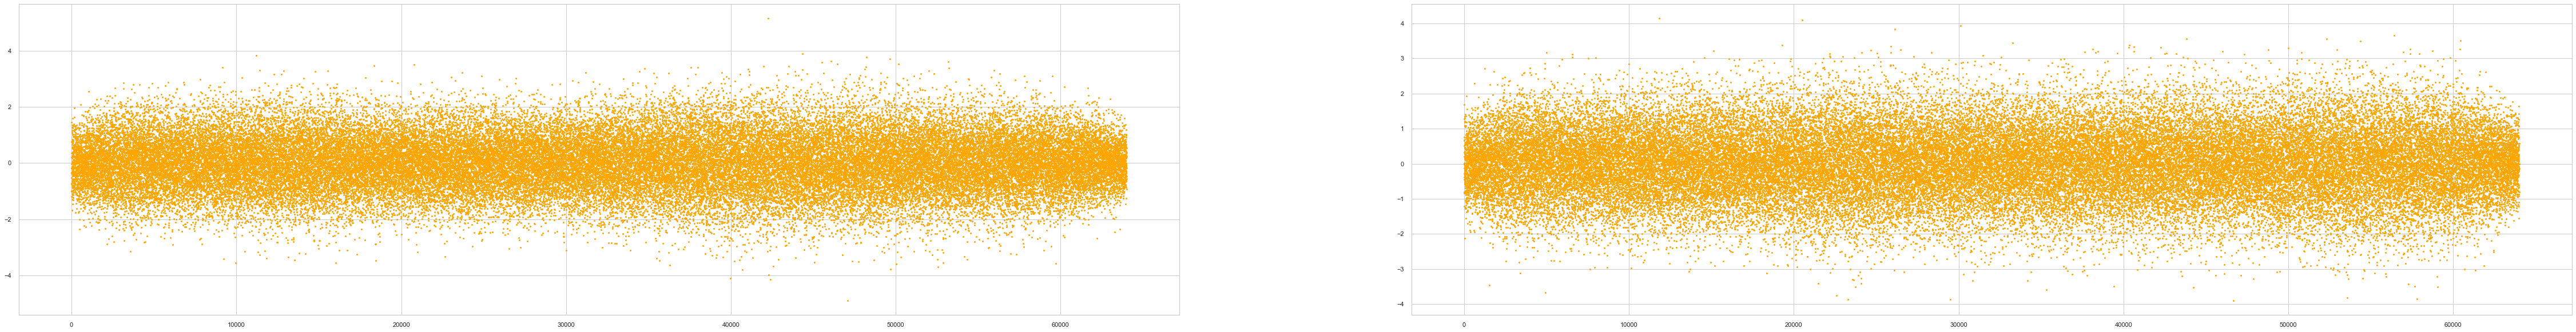

In [11]:
lin, col = 1, 2
fig = plt.figure(figsize=(lin, col))
subPlotS = []
for i in range(lin):
    for j in range(col):
        subPlotS.append(fig.add_subplot(lin , col, (i*col)+j+1))
              
for i in range(lin):
    for j in range(col):
        gen_noise = np.random.normal(0, 1, (1,NOISE_DIM))
        gen_test = GAN.gen.predict(gen_noise).flatten()
        ipd.display(ipd.Audio(data=gen_test, rate=SAMPLE_RATE))
        subPlotS[(i*col)+j].plot(gen_test, '.', color='orange')

plt.gcf().set_size_inches(80, 10)
plt.show()

##### Original Audio Samples

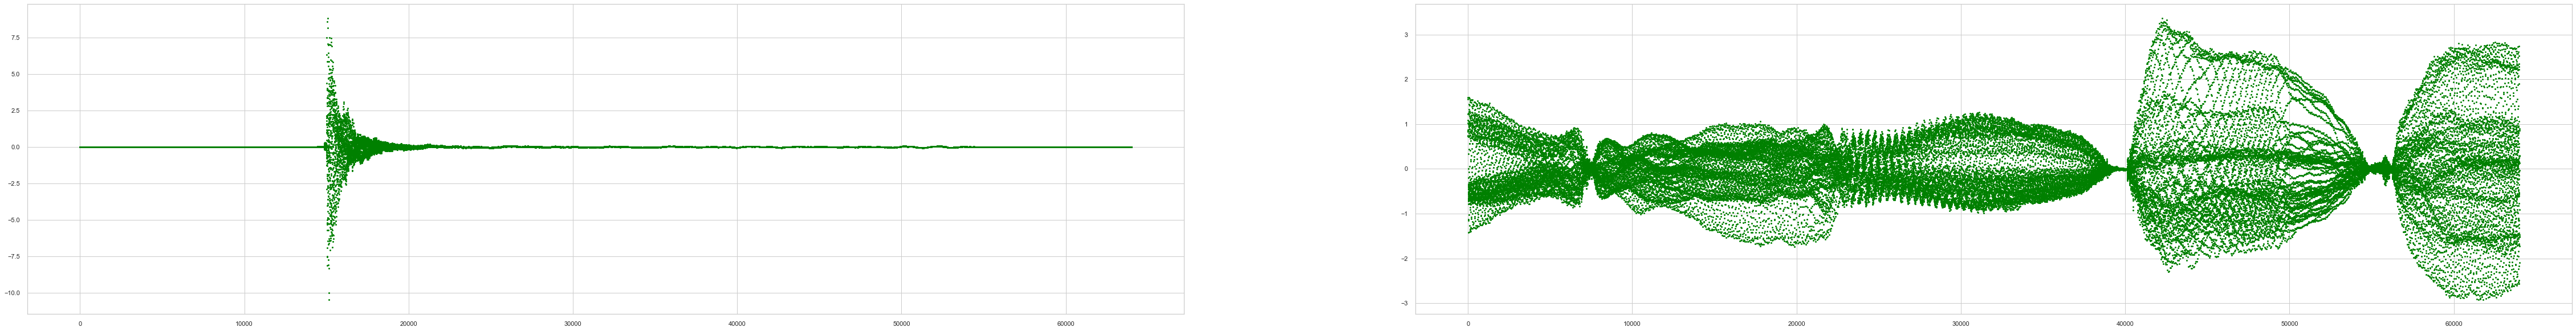

In [12]:
lin, col = 1, 2
fig = plt.figure(figsize=(lin, col))
subPlotS = []
for i in range(lin):
    for j in range(col):
        subPlotS.append(fig.add_subplot(lin , col, (i*col)+j+1))
            
for i in range(lin):
    for j in range(col):
        random_index = np.random.randint(0, len(GAN.trainData))
        original = GAN.trainData[random_index]
        ipd.display(ipd.Audio(data=original, rate=SAMPLE_RATE))
        subPlotS[(i*col)+j].plot(original, '.', color='green')

plt.gcf().set_size_inches(80, 10)
plt.show()

#### 4. Wrap Up<a id='audio_gan_wrap_up'></a> 

[Sections](#sections_audio_gan)

**Discussion & Closing:**

Generative adversarial networks (GANs) are an interesting innovation in machine learning, but it is also giving rise to controversy at the same time. One of the common reasons is the instability of convergence produced by the model, which makes the interpretation become subjective. As ones keep tracking the reasons why the model fails to converge, many more challenges will be uncovered; and it could lead to the question: if we began from the “right” start, instead of competing against the random noise, it may be helpful to compete against the “**non** random noise” dataset. This is because the random-noise data may give a false sense to the Discriminator that the data is fake; but in the actual fact, the fake data can be also found in the ground truth dataset. Regardless, the idea of GANs model does give a fresh perspective to approach problems and it is worth to be explored and enhanced further.

To wrap up, the objective of this notebook is to demo the basic steps of constructing a GANs model for sound generation. Hopefully, this brief presentation gives you some ideas on my skill sets in general. Once again, thank you for considering me.